# Project

##### Installation Requirements : 

https://pypi.org/project/apriltag/ 

pip install apriltag

https://github.com/TaipanRex/pyvisgraph

pip install pyvisgraph

https://pypi.org/project/opencv-python/

pip install opencv-python



In [1]:
from computer_vision import * 
from navigation import * 
from kalman import *
from utils import * 

# Import tdmclient Notebook environment:
import tdmclient.notebook
import time

In [2]:
@tdmclient.notebook.sync_var
def get_prox_values():
        return prox_horizontal

In [3]:
@tdmclient.notebook.sync_var
def set_motors(l_speed,r_speed):
    global motor_left_target, motor_right_target
    motor_left_target=l_speed
    motor_right_target=r_speed

In [4]:
@tdmclient.notebook.sync_var
def get_motors():
    global motor_left_speed, motor_right_speed
    return (motor_left_speed, motor_right_speed)

## Compute Field

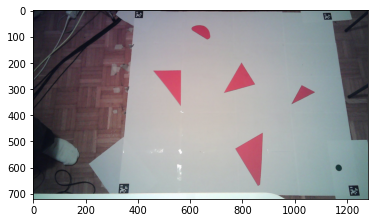

In [9]:
# Initialize Objects
webcam = Webcam(1)
vision = ComputerVision(black_th, red_th, green_th, field_size)
robot  = Robot()
# See what webcam input look like 
image = webcam.get_frame(display=True)

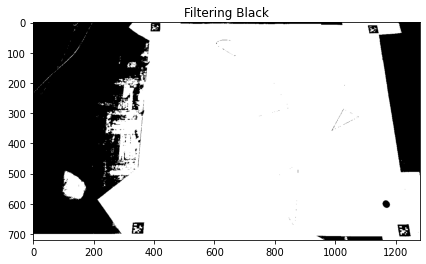

In [10]:
# Re-try detection until all corners detected
image = webcam.get_frame(display=False)
while not(vision.detect_corner_tags(image)) : 
    image = webcam.get_frame(display=False)
    vision.detect_corner_tags(image)

## Obstacles Detection 
- Run this cell before placing thymio on field because red lights from thymio sensors are sometimes recognized as obstacles. 

In [11]:
# First Detection 
init_field_map, thymio_tag, final_goal, obstacles = vision.detection(image)

Thymio Not Detected


## Path Planning 
- Now Put thymio on its starting position  

In [12]:
# Thymio detection and Path Planning 
image = webcam.get_frame()
thymio_tag = vision.thymio_detection(vision.get_field(image)) 
robot.update_position(thymio_tag)
robot.path_planning(init_field_map, final_goal, obstacles)

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 148.86it/s]


## Main Loop

In [ ]:
await tdmclient.notebook.start()
boolKF = False
count = 0
kalman = Kalman(robot)
while True : 
    
    if count == 0:
        
        #------------VISION------------#

        # Get image from webcam
        image = webcam.get_frame()
        field_map = init_field_map.copy()
        
        # Detection 
        thymio_tag = vision.thymio_detection(vision.get_field(image))
        if thymio_tag:
            robot.update_cam_pos(thymio_tag)
            
        # -- Drawing -- 
        # Get map with obstacles and goal 
        field_map = init_field_map.copy()
        robot.draw_path(field_map)  
        vision.draw_thymio_tag(field_map, thymio_tag)
        robot.draw_thymio(field_map)
        cv2.imshow('Field', field_map[:, :, ::-1])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            cv2.waitKey(1)
            webcam.release()
        
        # Indicate that the last block was the vision 
        boolKF = True
        count+=1
        
    #------------FILTERING------------
    
    else :
        # Get the value of the motors of the Thymio
        [L_speed,R_speed] = get_motors()      
        
        if boolKF is True:
            # Last block was the vision 
            if thymio_tag is None:
                # The Thymio tag is not detected so we predict the Thymio's state from the odometry
                kalman.kalman_prediction(robot,L_speed,R_speed)
                # Indicate that last block was not vision (Kalman_prediction)
                boolKF = False
            else:
                # The Thymio tag is detected so we can update the Thymio's state with the webcam
                # Indicate that last block was not vision (Kalman_update)
                boolKF = kalman.kalman_update(robot)
        
        elif boolKF is False:
            # Last block wasn't the vision so we predict the Thymio's state from the odometry
            kalman.kalman_prediction(robot,L_speed,R_speed)   

            
            
        #------------MOTION------------
        
        #Update Goal 
        robot.update_next_goal(tolerance=10)  
        #if end reached -> stop and exit
        if robot.finished:
            set_motors(0,0)
            break

        deviation = robot.compute_deviation()
        prox_values = get_prox_values()

        #speed to reach goal
        L_speed_goal = speed + devGain * deviation
        R_speed_goal = speed - devGain * deviation

        #store front sensor values
        for i in range(5):
            # Get and scale inputs
            x[i] = prox_values[i]//sensor_scale

        #Memory
        x[5] = L_speed_obstacle//mem_decay
        x[6] = R_speed_obstacle//mem_decay

        #Reset obstacle speeds after storing
        L_speed_obstacle = 0
        R_speed_obstacle = 0

        #compute outputs of neurons
        for i in range(len(x)):    
            L_speed_obstacle += x[i] * w_l[i]
            R_speed_obstacle += x[i] * w_r[i]

        #sum speeds to reach goal and to avoid obstacle
        L_speed = L_speed_goal + L_speed_obstacle
        R_speed = R_speed_goal + R_speed_obstacle

        #apply new speed to motors
        set_motors(int(L_speed), int(R_speed))
        robot.L_speed = L_speed
        robot.R_speed = R_speed

        if count==MOTION_RATIO:
            count=0
        else:
            count+=1